# Reproduce the Latini 2023 model

>Latini Sara, Venafra Veronica, Massacci Giorgia, Bica Valeria, Graziosi Simone, Pugliese Giusj Monia, Iannuccelli Marta, Frioni Filippo, Minnella Gessica, Marra John Donald, Chiusolo Patrizia, Pepe Gerardo, Helmer-Citterich Manuela, Mougiakakos Dimitrios, Boettcher Martin, Fischer Thomas, Perfetto Livia, Sacco Francesca (2023) Unveiling the signaling network of FLT3-ITD AML improves drug sensitivity prediction eLife 12:RP90532
https://doi.org/10.7554/eLife.90532.1

**Goal:**
   
To investigate drug sensitivity using genotype specific Boolean models.

**Knowledge source:**
  
1. The SIGNOR database,  to build a prior-knowledge network (PKN) recapitulating known signaling pathways downstream of the FLT3 receptor.
2. Experiments results of the activity status of the sentinel proteins under 16 different perturbation conditions in TKIs sensitive and resistant cells to generate the training dataset.


**Representation:**
  
Boolean network  
![Figure 3](Figure3.png) 

**Tools:**
  
1. CellNOptR was used to derive biologically relevant information from the training dataset and generate FLT3-ITD-specific predictive models
2. ProxPath algorithm, a graph-based method that given a set of proteins, estimates its regulatory impact over phenotypes and pathways annotated in SIGNOR

**in silico & in vitro validation:**
  
1. They performed a targeted in silico approach in FLT3-ITD-TKD and FLT3-ITD-JMD cells, by simulating the levels of apoptosis and proliferation, upon combinatorial knockout of FLT3 and one of the following key druggable kinases: ERK1/2, MEK1/2, GSK3A/B, IGF1R, JNK, KRAS, MEK1/2, mTOR, PDPK1, PI3K, p38.
2. Then tested in vitro whether the pharmacological suppression of JNK using a highly selective inhibitor could increase the sensitivity of FLT3ITD-TKD cells to TKI treatment.
3. They have also used patients’ data to perform an in silico combined treatment of patients simulating their mutations with the inhibition of FLT3 and a key signaling kinase.

In [1]:
import ginsim
import biolqm
import maboss
import pypint
import pandas as pd
import numpy as np
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
import seaborn as sns # for heatmap visualization
#import pyboolnet # for reproduce the original results

This notebook has been executed using the docker image `colomoto/colomoto-docker:2024-01-01`

## Network import

The model is exported from their GitHub repository [SaccoPerfettoLab/FLT3-ITD_driven_AML_Boolean_models](https://github.com/SaccoPerfettoLab/FLT3-ITD_driven_AML_Boolean_models).

The following R codes are excecuted in R version 4.3.2 (2023-10-31) to generate the models in SBML-qual format:


Then visualize the two SBML-qual models.

In [2]:
# Load the data
JMD_lqm = biolqm.load("Latini2023_JMD.sbml")

# Use the GinSIM package to visualize it
JMD_lrg = biolqm.to_ginsim(JMD_lqm)
ginsim.show(JMD_lrg)

In [3]:
TKD_lqm = biolqm.load("Latini2023_TKD.sbml")
TKD_lrg = biolqm.to_ginsim(TKD_lqm)
ginsim.show(TKD_lrg)

The visualization looks different from Figure 3B and 3C in the paper. It is because figures in the paper only shows the edges (and nodes) with highest edge confidence (frequency in 100 models > 0.4). The codes do generate exact the same models as the paper used in the following assessment steps.

# Assessment of the models
As described in the paper:  
>At this point, we aimed to assess whether the newly generated FLT3 ITD-JMD and FLT3 ITD-TKD Boolean models could recapitulate in silico the TKI-induced modulation of apoptosis and proliferation. 
>To this aim, we defined a strategy that is composed of three steps:
>1. We set up two initial conditions of the models aiming at reproducing the biological context of our cells before and after the FLT3 inhibitor treatment.
>2. We computed the steady state of each Boolean model to derive the states of the model’s proteins associated to each initial condition.
>3. We unbiasedly associated the final conditions to phenotypic states of the cells.

## Simulations before and after the FLT3 inhibitor treatment

>Briefly, we defined “Untreated” the condition that reproduce a malignant state where cells proliferate and escape apoptosis. From the model perspective this condition is represented by an active state of the FLT3, IGF1R, and TNFR nodes.  
>Next, we defined “FLT3i” the condition that reproduces malignant cells treated with the FLT3 inhibitor (Midostaurin). From the model perspective this condition is represented by an active state of the IGF1R, and TNFR nodes and an inactive state of FLT3.

As shown in Figure S4:  

![Figure S4](FigureS4.png)  
Steady states of FLT3 ITD-JMD (upper panel) and TKD (lower panel) Boolean models in FLT3 inhibition and control conditions. Proteins are red (active) or blue (inactive). The regulators of Proliferation and Apoptosis are reported in green and orange, respectively.

We are going to reproduce these results.

### Approach
In the original paper, R package CellNOptR is used to assemble the model and to compute its steady states. Here we adopt a different approach using Python library `bioLQM`. The `biolqm.fixpoints` function could be used to compute the complete list of logical stable states (or fixpoints) of the model.

### Experiment Set-up
According to the paper, we are going to set up the simulations on each conditions: 
- Untreated condition, in which all the receptors included in the model (FLT3, IGF1R, and TNFR) are set to ON.
- FLT3 inhibition condition (FLT3i), in which FLT3 was set to OFF.

In [4]:
# set the fix value for the simulations
JMD_untreated = biolqm.perturbation(JMD_lqm, "FLT3%1 IGF1R%1 TNF%1")
JMD_flt3i = biolqm.perturbation(JMD_lqm, "FLT3%0 IGF1R%1 TNF%1")
TKD_untreated = biolqm.perturbation(TKD_lqm, "FLT3%1 IGF1R%1 TNF%1")
TKD_flt3i = biolqm.perturbation(TKD_lqm, "FLT3%0 IGF1R%1 TNF%1")

### Stable states calculation

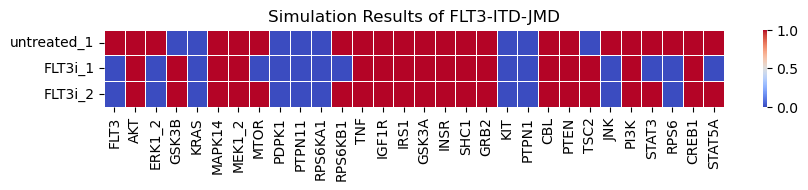

In [5]:
## For the JMD model
df_simResT0 = pd.DataFrame(biolqm.fixpoints(JMD_untreated))
df_simResT1 = pd.DataFrame(biolqm.fixpoints(JMD_flt3i))

# Create a combined DataFrame for the heatmap
combined_df_JMD = pd.concat([df_simResT0, df_simResT1],ignore_index=True)

# Create labels
num_rows_t0 = len(df_simResT0)
num_rows_t1 = len(df_simResT1)
labels_t0 = [f'untreated_{i+1}' for i in range(num_rows_t0)]
labels_t1 = [f'FLT3i_{i+1}' for i in range(num_rows_t1)]
combined_labels = labels_t0 + labels_t1

# Define color palette
myColor = sns.color_palette("coolwarm", as_cmap=True)

# Plotting the heatmap
plt.figure(figsize=(10, 1))
ax = sns.heatmap(combined_df_JMD, cmap=myColor, annot=False, cbar_kws={'ticks': [0, 0.5, 1]}, linewidths=.5)
ax.set_yticklabels(combined_labels, rotation=0)
plt.title('Simulation Results of FLT3-ITD-JMD')
plt.show()

Compared with the original resuts:  
<img src="sim_JMD.png" alt="drawing" width="800"/>    
**Conclusion: for the JMD model, We have derived the same simulaiton results, except an addtional stable state of the FLT3i simulation.**

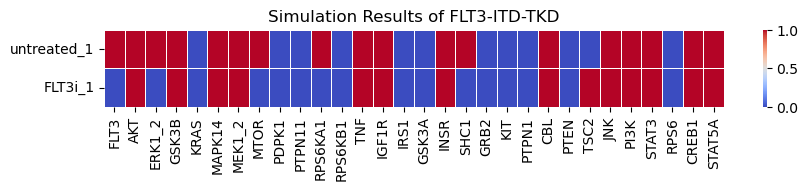

In [6]:
## For the TKD model
df_simResT0 = pd.DataFrame(biolqm.fixpoints(TKD_untreated))
df_simResT1 = pd.DataFrame(biolqm.fixpoints(TKD_flt3i))

# Create a combined DataFrame for the heatmap
combined_df_TKD = pd.concat([df_simResT0, df_simResT1],ignore_index=True)

# Create labels
num_rows_t0 = len(df_simResT0)
num_rows_t1 = len(df_simResT1)
labels_t0 = [f'untreated_{i+1}' for i in range(num_rows_t0)]
labels_t1 = [f'FLT3i_{i+1}' for i in range(num_rows_t1)]
combined_labels = labels_t0 + labels_t1

# Define color palette
myColor = sns.color_palette("coolwarm", as_cmap=True)

# Plotting the heatmap
plt.figure(figsize=(10, 1))
ax = sns.heatmap(combined_df_TKD, cmap=myColor, annot=False, cbar_kws={'ticks': [0, 0.5, 1]}, linewidths=.5)
ax.set_yticklabels(combined_labels, rotation=0)
plt.title('Simulation Results of FLT3-ITD-TKD')
plt.show()

Compared with the original resuts:  
<img src="sim_TKD.png" alt="drawing" width="800"/>    
**Conclusion: for the TKD model, We have derived exactly the same simulaiton results.**

## Apoptosis and proliferation activity inference

As described in the supplementary methods:
> To functionally interpret the results of the simulations, we derived the levels of ‘apoptosis inhibition’ and ‘proliferation activation’ in each condition (Figure 3E). To do that:
> 1. We annotated all the proteins in the network as activators or inhibitors of ‘apoptosis’ and ‘proliferation’ phenotypes using our recently published research ProxPath (Iannuccelli et al., 2022).
> 2. For the inference of phenotypes, we considered only proteins that were (i) regulators of a phenotype and (ii) endpoint proteins in high-confidence signaling axes (edge frequency 0.4, Figure 3B e 3C). This choice is driven by the need to avoid redundancy and consider the final nodes of the model which are the real effector proteins according to our mutations-specific FLT3 Boolean models.
> 3. Then, we integrated the signal of the phenotype regulators proteins (Figure 3E heatmaps) to compute the level of ‘apoptosis inhibition’ and ‘proliferation activation’ in each cell line (Figure 3E barplot). Integration, in this context, means computing the sum of the 'scores' of proteins that influence each phenotype, with an underlying assumption of equal importance for both inhibitors and activators (OR logic).  

>As a result of this step, we obtained a comprehensive model encompassing proteins and phenotypes (apoptosis and proliferation) that can possess multiple values, effectively creating a multi-valued model. This enhancement enables a finer comparison between different cell lines.

In [7]:
# Read the apoptosis and proliferation data generated by ProxPath
apoptosis_df = pd.read_csv('paths_to_apoptosis_proliferation.txt', sep='\t')
apoptosis_df['node'] = apoptosis_df['QueryNode'].str.replace('/', '_')
apoptosis_df = apoptosis_df[['node', 'EndNode', 'Final_Effect']].rename(columns={'EndNode': 'phenotype', 'Final_Effect': 'apoptosis'})
apoptosis_df.head()

,node,phenotype,apoptosis
0,STAT5A,APOPTOSIS,-1
1,MTOR,APOPTOSIS,-1
2,JNK,APOPTOSIS,1
3,AKT,APOPTOSIS,-1
4,AKT,APOPTOSIS,-1


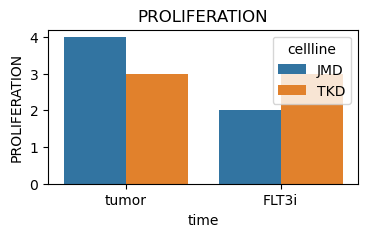

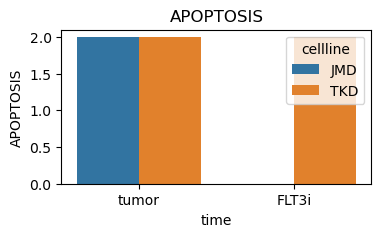

In [8]:
# Transpose and select only the first two columns (the identical stable states)
combined_df_JMD_tidy = combined_df_JMD.head(2).T.reset_index()
combined_df_JMD_tidy.columns = ['node', 'tumor', 'FLT3i']
combined_df_TKD_tidy = combined_df_TKD.head(2).T.reset_index()
combined_df_TKD_tidy.columns = ['node', 'tumor', 'FLT3i']

# Ensure matching data types
combined_df_JMD_tidy['node'] = combined_df_JMD_tidy['node'].astype(str)
combined_df_TKD_tidy['node'] = combined_df_TKD_tidy['node'].astype(str)
apoptosis_df['node'] = apoptosis_df['node'].astype(str)

# Specify edges/nodes with high confidence (>.4) for each cell line and phenotype
allowed_nodes_apo_JMD = ['MTOR', 'STAT5A']
allowed_nodes_apo_TKD = ['STAT5A', 'AKT']
allowed_nodes_pro_JMD = ['PI3K', 'MAPK14', 'STAT5A', 'MTOR']
allowed_nodes_pro_TKD = ['PI3K', 'KRAS', 'CREB1', 'STAT5A']

# Compute States for Apoptosis and Proliferation
phens = ['PROLIFERATION', 'APOPTOSIS']
results = {}

for phen in phens:
    apoptosis_annotation = apoptosis_df[apoptosis_df['phenotype'] == phen][['node', 'apoptosis']].drop_duplicates()

    annotated_JMD = combined_df_JMD_tidy.merge(apoptosis_annotation, on='node', how='inner')
    annotated_TKD = combined_df_TKD_tidy.merge(apoptosis_annotation, on='node', how='inner')

    # Further filtering based on nodes as in their codes:
    
  # Select only the regulators in each cell line that are endpoint proteins
  # in high-confidence signaling axes (edge frequency 0.4). As such, 
  # if two regulators of the same phenotype were linked in the same axis, 
  # we considered only the one at the end of the cascade.
    
    if phen == 'APOPTOSIS':
        annotated_JMD = annotated_JMD[annotated_JMD['node'].isin(allowed_nodes_apo_JMD)]
        annotated_TKD = annotated_TKD[annotated_TKD['node'].isin(allowed_nodes_apo_TKD)]
    else:  # PROLIFERATION
        annotated_JMD = annotated_JMD[annotated_JMD['node'].isin(allowed_nodes_pro_JMD)]
        annotated_TKD = annotated_TKD[annotated_TKD['node'].isin(allowed_nodes_pro_TKD)]

    # Compute the states
    # Multiply and sum as per the R code
    for df, cellline in zip([annotated_JMD, annotated_TKD], ['JMD', 'TKD']):
        df['tumor_apo'] = df['tumor'] * df['apoptosis']
        df['FLT3i_apo'] = df['FLT3i'] * df['apoptosis']
        tumor_sum = df['tumor_apo'].sum()
        FLT3i_sum = df['FLT3i_apo'].sum()
        results[f'{cellline}_{phen}'] = {'tumor': tumor_sum, 'FLT3i': FLT3i_sum}

# Create Bar Plots
plot_data = []
for key, value in results.items():
    cellline, phen = key.split('_')
    for treatment, apo_value in value.items():
        if phen == 'APOPTOSIS':
            apo_value *= -1
        plot_data.append({'cellline': cellline, 'time': treatment, 'apoptosis': apo_value, 'phen': phen})

plot_df = pd.DataFrame(plot_data)

# Plotting
for phen in phens:
    plt.figure(figsize=(4, 2))
    df_plot = plot_df[plot_df['phen'] == phen]
    ax = sns.barplot(x='time', y='apoptosis', hue='cellline', data=df_plot)
    ax.set_ylabel(phen)
    plt.title(phen)
    plt.show()

Compared with the results in Figure 3E in the paper:    
![Figure 3Ebar](Figure3Ebar.png)   
**The results are identical.**

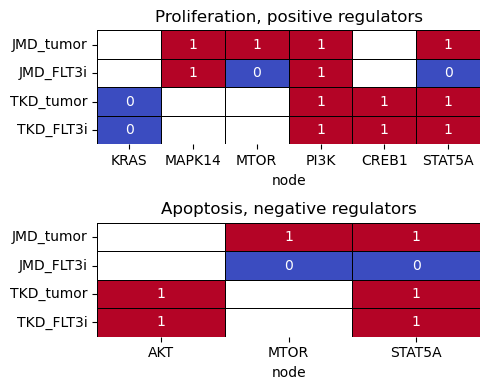

In [9]:
# Define the nodes relevant to each phenotype
apoptosis_nodes = ['AKT', 'MTOR', 'STAT5A']
proliferation_nodes = ['KRAS', 'MAPK14', 'MTOR', 'PI3K', 'CREB1', 'STAT5A']

# Function to build heatmap data
def build_heatmap_data(df, phenotype_nodes, cell_line_name, allowed_nodes):
    # Filter for relevant nodes
    phenotype_data = df[df['node'].isin(phenotype_nodes)].copy()

    # Melt the DataFrame to long format
    phenotype_data_melted = phenotype_data.melt(id_vars='node', var_name='condition', value_name='value')

    # Set values to NaN for nodes not in allowed_nodes
    phenotype_data_melted['value'] = phenotype_data_melted.apply(
        lambda row: np.nan if row['node'] not in allowed_nodes else row['value'], axis=1)

    # Pivot to create the heatmap data
    heatmap_data = phenotype_data_melted.pivot_table(index='node', columns='condition', values='value', aggfunc='first')
    
    # Rename the columns to match the cell line names
    heatmap_data.columns = [f'{cell_line_name}_{col}' for col in heatmap_data.columns]
    
    return heatmap_data

# Create heatmap data
heatmap_data_apo_JMD = build_heatmap_data(combined_df_JMD_tidy, apoptosis_nodes, 'JMD', allowed_nodes_apo_JMD)
heatmap_data_apo_TKD = build_heatmap_data(combined_df_TKD_tidy, apoptosis_nodes, 'TKD', allowed_nodes_apo_TKD)
heatmap_data_pro_JMD = build_heatmap_data(combined_df_JMD_tidy, proliferation_nodes, 'JMD', allowed_nodes_pro_JMD)
heatmap_data_pro_TKD = build_heatmap_data(combined_df_TKD_tidy, proliferation_nodes, 'TKD', allowed_nodes_pro_TKD)

# Combine JMD and TKD for each phenotype
heatmap_data_apo = pd.concat([heatmap_data_apo_JMD, heatmap_data_apo_TKD], axis=1)
heatmap_data_pro = pd.concat([heatmap_data_pro_JMD, heatmap_data_pro_TKD], axis=1)

# Define color map for the heatmap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Reorder the columns and rows to make it identical to the paper
columns_order_apo = ['JMD_tumor', 'JMD_FLT3i', 'TKD_tumor', 'TKD_FLT3i']
columns_order_pro = ['JMD_tumor', 'JMD_FLT3i', 'TKD_tumor', 'TKD_FLT3i']
heatmap_data_pro_reordered = heatmap_data_pro[columns_order_apo].reindex(proliferation_nodes)
heatmap_data_apo_reordered = heatmap_data_apo[columns_order_apo].reindex(apoptosis_nodes)

# Plotting the heatmaps
plt.figure(figsize=(5, 4))

# Proliferation heatmap
plt.subplot(2, 1, 1)
sns.heatmap(heatmap_data_pro_reordered.T, cmap=cmap, annot=True, cbar=False, linewidths=.5, linecolor='black')
plt.title('Proliferation, positive regulators')

# Apoptosis heatmap
plt.subplot(2, 1, 2)
sns.heatmap(heatmap_data_apo_reordered.T, cmap=cmap, annot=True, cbar=False, linewidths=.5, linecolor='black')
plt.title('Apoptosis, negative regulators')

plt.tight_layout()
plt.show()

Compared with the results in Figure 3E in the paper:  
![Figure 3Ehm](Figure3Ehm.png)   
**The results are identical.**

## Further assessment and applications of the models

Next, the authors have simulated the levels of apoptosis and proliferation, upon combinatorial knockout of FLT3 and one of the following key druggable kinases: ERK1/2, MEK1/2, GSK3A/B, IGF1R, JNK, KRAS, MEK1/2, mTOR, PDPK1, PI3K, p38, to predict novel combinatorial treatments reverting drug resistance of FLT3-ITD cells. Since the same strategy was used in this section, the results should also be identical and thus are skipped here.  

### Clinical outcomes
Using the same strategy as in [Palma 2021](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7916657/), I next compare the phenotype scores with clinical features derived from the AML TGCA dataset. Specifically, the mutation-specific peripheral blood (PB) and bone marrow (BM) blast percentages with the predictions of our models.

The integrated network score is calculated by substracting the proliferation score by the apoptosis score.   
     
Mutation and clinical data are downloaded from the [NIH GDC website](https://gdc.cancer.gov/about-data/publications/laml_2012):
1. [Supplemental Table 06: All somatic mutations with annotation and readcounts from DNA and RNA sequencing](SupplementalTable06.tsv)
2. [Patient Clinical Data](https://portal.gdc.cancer.gov/files/c07a64a0-7588-4653-95ef-982b41a1a804?aeTable_offset=20)

In [ ]:
# Data file path
tsv_file_path_genes = 'SupplementalTable06.tsv'
tsv_file_path_clinical = 'nationwidechildrens.org_clinical_patient_laml.txt'

# Mutation data
df_genes = pd.read_csv(tsv_file_path_genes, sep='\t', usecols=['TCGA_id', 'gene_name'])

# clinical data 
df_clinical = pd.read_csv(tsv_file_path_clinical, sep='\t', usecols=['bcr_patient_barcode', 
                                                            'blast_count',
                                                            'percent_blasts_peripheral_blood'])


In [10]:
results

{'JMD_PROLIFERATION': {'tumor': 4, 'FLT3i': 2},
 'TKD_PROLIFERATION': {'tumor': 3, 'FLT3i': 3},
 'JMD_APOPTOSIS': {'tumor': -2, 'FLT3i': 0},
 'TKD_APOPTOSIS': {'tumor': -2, 'FLT3i': -2}}

In [12]:
type(results)

dict

## Conclusion
**Results from the Latini et al. 2023 paper are reproducible, and identical results could be generated using different platforms (Python versus R).**   
